# Sentiment Analysis of Stock Twits with VADER

### Import libs

In [1]:
#### NLP LIBS ###
import nltk
import numpy as np
import pandas as pd
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Import utils function ###
from utils import get_tweets_from_db, eval_model, URI, DB_NAME
from cleaning_utils import full_preprocess

[nltk_data] Downloading package vader_lexicon to /home/fast-
[nltk_data]     pc-2023/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df_apple_tweets = pd.read_parquet('balanced_250k.parquet')
df_apple_tweets['cleaned_content'] = df_apple_tweets['content_cleaned']
df_apple_tweets

,date,content,true_sentiment,content_cleaned,cleaned_content
139036,2017-05-09T20:32:06Z,$AAPL I wanna sell some shares to buy me an #a...,1.0,cashtag I wanna sell some shares to buy me an...,cashtag I wanna sell some shares to buy me an...
981796,2023-02-08T21:31:58Z,"$HOOD Don't forget $AAPL tomorrow, headed to 157+",1.0,"cashtag Don't forget cashtag tomorrow, heade...","cashtag Don't forget cashtag tomorrow, heade..."
359413,2022-05-13T08:55:11Z,$AAPL Another fake upside move… \nTake profi...,0.0,cashtag Another fake upside move… \nTake pr...,cashtag Another fake upside move… \nTake pr...
2199286,2019-09-18T06:02:46Z,$AAPL iPhone 11 preorder goes well in China,1.0,cashtag iPhone 11 preorder goes well in China,cashtag iPhone 11 preorder goes well in China
225978,2023-06-05T13:57:33Z,$SPY $AAPL Headlines and clickbait articles li...,0.0,cashtag cashtag Headlines and clickbait arti...,cashtag cashtag Headlines and clickbait arti...
...,...,...,...,...,...
1353599,2019-08-13T19:38:54Z,$TRNX damm pls $AAPL pls $MSFT pls $NFLX take ...,1.0,cashtag damm pls cashtag pls cashtag pls ca...,cashtag damm pls cashtag pls cashtag pls ca...
1502926,2013-03-12T18:39:41Z,$AAPL IDC Jan 31 2013 &quot;iPad accounted for...,1.0,cashtag IDC Jan 31 2013 &quot;iPad accounted ...,cashtag IDC Jan 31 2013 &quot;iPad accounted ...
1767016,2021-09-02T14:25:34Z,$AAPL bears are silly!,1.0,cashtag bears are silly!,cashtag bears are silly!
1801456,2023-11-02T19:59:27Z,$AAPL just sold the iPhone I just bought for d...,0.0,cashtag just sold the iPhone I just bought fo...,cashtag just sold the iPhone I just bought fo...


## Compute sentiment score with VADER algorithm

In [19]:
sid = SentimentIntensityAnalyzer()

def compute_sentiment_score_VADER(tweet):
    scores = sid.polarity_scores(tweet)
    sentiment_dict = {'tweet':tweet, 'bullish_score': scores['pos'], 'bearish_score': scores['neg'], 'neutral_score': scores['neu'], 'compound_score': scores['compound']}
    return sentiment_dict

list_dict = list()

for tweet in df_apple_tweets["content"]:
    sentiment = compute_sentiment_score_VADER(tweet)
    list_dict.append(sentiment) 

df_sentiment = pd.DataFrame(list_dict)
df_sentiment

,tweet,bullish_score,bearish_score,neutral_score,compound_score
0,$AAPL I wanna sell some shares to buy me an #a...,0.379,0.000,0.621,0.9159
1,"$HOOD Don't forget $AAPL tomorrow, headed to 157+",0.192,0.000,0.808,0.1695
2,$AAPL Another fake upside move… \nTake profi...,0.193,0.207,0.600,-0.0516
3,$AAPL iPhone 11 preorder goes well in China,0.231,0.000,0.769,0.2732
4,$SPY $AAPL Headlines and clickbait articles li...,0.235,0.000,0.765,0.5106
...,...,...,...,...,...
249995,$TRNX damm pls $AAPL pls $MSFT pls $NFLX take ...,0.136,0.375,0.488,-0.8709
249996,$AAPL IDC Jan 31 2013 &quot;iPad accounted for...,0.077,0.000,0.923,0.2732
249997,$AAPL bears are silly!,0.317,0.000,0.683,0.1007
249998,$AAPL just sold the iPhone I just bought for d...,0.242,0.000,0.758,0.4939


#### Post-Processing: Compute the predicted label
* `bullish`
* `bearish`

In [20]:
df_apple_tweets["predicted_sentiment"] = df_sentiment.apply(lambda row: 0 if row['bullish_score'] > row['bearish_score'] else 1, axis=1).values
df_apple_tweets

,date,content,true_sentiment,content_cleaned,cleaned_content,predicted_sentiment
139036,2017-05-09T20:32:06Z,$AAPL I wanna sell some shares to buy me an #a...,1.0,cashtag I wanna sell some shares to buy me an...,cashtag I wanna sell some shares to buy me an...,0
981796,2023-02-08T21:31:58Z,"$HOOD Don't forget $AAPL tomorrow, headed to 157+",1.0,"cashtag Don't forget cashtag tomorrow, heade...","cashtag Don't forget cashtag tomorrow, heade...",0
359413,2022-05-13T08:55:11Z,$AAPL Another fake upside move… \nTake profi...,0.0,cashtag Another fake upside move… \nTake pr...,cashtag Another fake upside move… \nTake pr...,1
2199286,2019-09-18T06:02:46Z,$AAPL iPhone 11 preorder goes well in China,1.0,cashtag iPhone 11 preorder goes well in China,cashtag iPhone 11 preorder goes well in China,0
225978,2023-06-05T13:57:33Z,$SPY $AAPL Headlines and clickbait articles li...,0.0,cashtag cashtag Headlines and clickbait arti...,cashtag cashtag Headlines and clickbait arti...,0
...,...,...,...,...,...,...
1353599,2019-08-13T19:38:54Z,$TRNX damm pls $AAPL pls $MSFT pls $NFLX take ...,1.0,cashtag damm pls cashtag pls cashtag pls ca...,cashtag damm pls cashtag pls cashtag pls ca...,1
1502926,2013-03-12T18:39:41Z,$AAPL IDC Jan 31 2013 &quot;iPad accounted for...,1.0,cashtag IDC Jan 31 2013 &quot;iPad accounted ...,cashtag IDC Jan 31 2013 &quot;iPad accounted ...,0
1767016,2021-09-02T14:25:34Z,$AAPL bears are silly!,1.0,cashtag bears are silly!,cashtag bears are silly!,0
1801456,2023-11-02T19:59:27Z,$AAPL just sold the iPhone I just bought for d...,0.0,cashtag just sold the iPhone I just bought fo...,cashtag just sold the iPhone I just bought fo...,0


### Model Evaluation

To evaluate the model performance prediction we compute the confusion matrix and the classification report

######## Classification Report ########

              precision    recall  f1-score   support

         0.0       0.43      0.30      0.35    125000
         1.0       0.46      0.60      0.52    125000

    accuracy                           0.45    250000
   macro avg       0.44      0.45      0.44    250000
weighted avg       0.44      0.45      0.44    250000

######## Accuracy Score ########
0.45



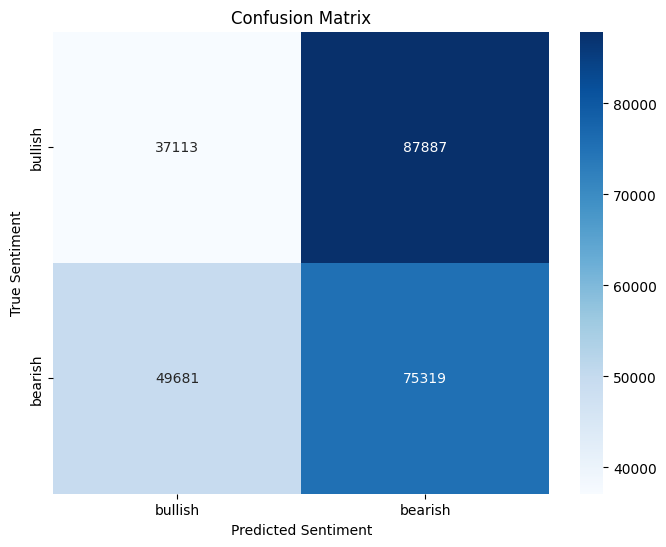

In [21]:
eval_model(df_apple_tweets.dropna()["true_sentiment"], df_apple_tweets.dropna()["predicted_sentiment"])